In [1]:
import xarray as xr
from xgcm import Grid
from matplotlib import pyplot as plt
import pandas as pd
from backgroung import *
import cartopy.crs as ccrs
import warnings
from IPython.core.display import SVG, HTML

In [2]:
model_path = 'http://barataria.tamu.edu:8080/thredds/dodsC/NcML/txla_hindcast_agg'
ds = xr.open_dataset(model_path)

In [3]:
ds.coords

Coordinates:
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
  * s_w         (s_w) float64 -1.0 -0.9667 -0.9333 ... -0.06667 -0.03333 0.0
    lon_rho     (eta_rho, xi_rho) float64 ...
    lat_rho     (eta_rho, xi_rho) float64 ...
    lon_u       (eta_u, xi_u) float64 ...
    lat_u       (eta_u, xi_u) float64 ...
    lon_v       (eta_v, xi_v) float64 ...
    lat_v       (eta_v, xi_v) float64 ...
    lon_psi     (eta_psi, xi_psi) float64 ...
    lat_psi     (eta_psi, xi_psi) float64 ...
  * ocean_time  (ocean_time) datetime64[ns] 1993-01-01T01:00:00 ... 2018-07-01

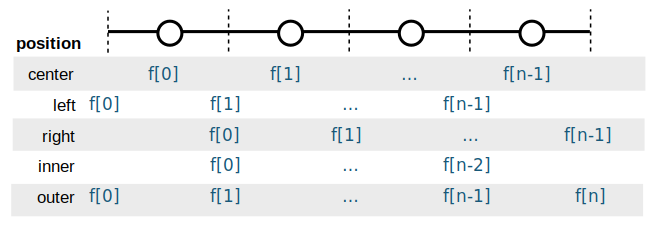

In [4]:
SVG(filename='/Users/vrx/src/xgcm/doc/images/axis_positions.svg')

In [5]:
rename_dict = {'eta_u':'eta_rho', 'xi_v':'xi_rho'}

def rename_redundant_dim(ds, rename_dict):
    for k,v in rename_dict.items():
        ds_full = ds.copy()
        # remove redundant dims
        drop_vars = [a for a in ds.keys() if k in ds[a].dims]
        ds = ds.drop(drop_vars)
        for d in ds_full.data_vars:
            if k in ds_full[d].dims:
                ds[d] = ds_full[d].rename({k:v})
        for c in ds_full.coords:
            if k in ds_full[c].dims:
                ds.coords[c] = ds_full[c].rename({k:v})
    return ds

ds = rename_redundant_dim(ds, rename_dict);

/Users/vrx/miniconda3/envs/owl/lib/python3.6/_collections_abc.py:720: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  yield from self._mapping


In [6]:
coords_dict = {'xi': {'center': 'xi_rho', 'inner': 'xi_u'},
               'eta': {'center': 'eta_rho', 'inner': 'eta_v'},
               's': {'center': 's_rho', 'outer': 's_w'}}
grid = Grid(ds, coords=coords_dict)
grid

<xgcm.Grid>
xi Axis (periodic):
  * center   xi_rho (671) --> inner
  * inner    xi_u (670) --> center
eta Axis (periodic):
  * center   eta_rho (191) --> inner
  * inner    eta_v (190) --> center
s Axis (periodic):
  * center   s_rho (30) --> outer
  * outer    s_w (31) --> center

In [7]:
ds.salt

<xarray.DataArray 'salt' (ocean_time: 223487, s_rho: 30, eta_rho: 191, xi_rho: 671)>
[859269522210 values with dtype=float32]
Coordinates:
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
    lon_rho     (eta_rho, xi_rho) float64 ...
    lat_rho     (eta_rho, xi_rho) float64 ...
  * ocean_time  (ocean_time) datetime64[ns] 1993-01-01T01:00:00 ... 2018-07-01
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:    salinity
    time:         ocean_time
    field:        salinity, scalar, series
    _ChunkSizes:  [  1  15  96 336]

In [8]:
ds.v

<xarray.DataArray 'v' (ocean_time: 223487, s_rho: 30, eta_v: 190, xi_rho: 671)>
[854770728900 values with dtype=float32]
Coordinates:
  * s_rho       (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
  * ocean_time  (ocean_time) datetime64[ns] 1993-01-01T01:00:00 ... 2018-07-01
    lon_v       (eta_v, xi_rho) float64 ...
    lat_v       (eta_v, xi_rho) float64 ...
Dimensions without coordinates: eta_v, xi_rho
Attributes:
    long_name:    v-momentum component
    units:        meter second-1
    time:         ocean_time
    field:        v-velocity, scalar, series
    _ChunkSizes:  [  1  15  95 336]

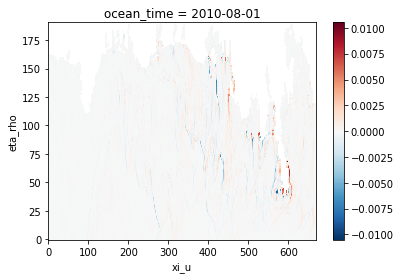

In [21]:
subset = ds.sel(ocean_time='2010-08-1').isel(s_rho=-1)
dsdx = grid.diff(subset.salt, 'xi')*grid.interp(subset.pm, 'xi')
dsdx.isel(ocean_time=0).plot()

In [22]:
us = subset.u*grid.interp(subset.salt, 'xi')

In [23]:
us

<xarray.DataArray (ocean_time: 24, eta_rho: 191, xi_u: 670)>
array([[[-17.180014, -16.964424, ...,   6.791047,   6.938031],
        [-17.386353, -17.677444, ...,   7.92552 ,   7.078331],
        ..., 
        [       nan,        nan, ...,        nan,        nan],
        [       nan,        nan, ...,        nan,        nan]],

       [[-17.208708, -17.008158, ...,   6.801733,   6.908571],
        [-17.398949, -17.72905 , ...,   7.699496,   7.008488],
        ..., 
        [       nan,        nan, ...,        nan,        nan],
        [       nan,        nan, ...,        nan,        nan]],

       ..., 
       [[-17.384237, -18.084167, ...,  13.734495,  13.752278],
        [-16.678324, -18.803938, ...,  14.308686,  13.764438],
        ..., 
        [       nan,        nan, ...,        nan,        nan],
        [       nan,        nan, ...,        nan,        nan]],

       [[-17.795597, -18.912437, ...,  13.778343,  14.049137],
        [-16.672298, -20.076456, ...,  14.835501,  14.31372